In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')
import pandas as pd
import numpy as np
import trading.start
import trading.portfolio as portfolio
import config.settings
from time import sleep
from core.utility import *
from trading.accountcurve import *
import data.db_mongo as db
import config.portfolios
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
p = portfolio.Portfolio(instruments=config.portfolios.p_trade)
i = p.instruments
from trading.bootstrap import bootstrap

Stock and shares are a type of financial instrument. The place they are traded is the stock market. People trade with the goal of maximising profits.
 
We trade financial instruments using simple computer models, that, based on past data, give us a reasonable chance of future success.
 
## Investing or Trading
Investing implies a buy-and-hold strategy. Under the ‘Fundamental Law of Active Management’, in order to gain market-beating returns (that is, to do consistently better than the market), we need to change our portfolio from time to time, to pick winners, and remove losers. We call this activity trading.
 
## Concept: Long & Short
On the stock market, when you buy a share, you are hoping the value will rise, and you can sell it for a profit. This is known as going long. In some markets, you can also do the reverse- that is, you can sell a share before you buy it. In this case, you are hoping the market will go down. This is known as going short.
 
## Concept: Commodities
Items which are generic are called commodities. Examples include oil, gas, gold, corn and foreign currencies. The price of the commodity is called the ‘spot rate’.
Concept: Futures Contracts
We don’t trade stocks and shares. We trade futures contracts (often just called ‘futures’), which are traded in a similar way, but offer some advantages for computer based traders.
 
A futures contract is an agreement to purchase a specific commodity at a specific time in the future, at a price known today.
 
### Example:
I am an airline and I have sold out tickets to a flight in 6 months time. The cost of fuel represents a large portion of my costs of operating the flight. The cost of fuel changes on a daily basis. A large rise in the price over the next six months might make the flight unprofitable.
 
In order to offset (‘hedge’) this risk, I will purchase a futures contract for the fuel, to be delivered in six months. I will pay the price of the futures contract today. The price of the futures contract today will be different from the spot rate of fuel (as it represents the expected price in six months time). If, on delivery, the spot price is lower, then I have lost out - I could have just purchased the fuel on the day I needed it. If, on the other hand, the spot price is higher than what I paid, I will be glad I bought that future six months ago.
Definition: Derivative
Any financial instrument whose price is derived from that of another instrument is called a ‘derivative’. The prices of gold futures, for example, would have prices derived from the (spot rate) price of gold. Futures are a type of derivative, although there are many others.
 
## Concept: Leverage
 
When purchasing stocks or shares, you typically pay with cash. Futures are different. With futures, you pay almost nothing for the future (for the purposes of this discussion, we will assume this amount is zero). This means you can purchase an almost limitless amount of futures contracts. This is called ‘trading on margin’.
 
One other key difference from stocks is that they are settled daily. This means that any profit or loss on the future is deposited daily in our account, in cash.
 
### Example: 
My trading account starts with \$10,000 in it. I purchase futures worth \$100,000. If those futures rise in price by 10%, I now have \$20,000. If they fall in value of by 10%, I have \$0- I am bust.
 
When we consider what futures to buy, we look not at the face value of the futures, but at volatility of returns.
 
In Python speak:

    returns = prices.diff()
    volatility_of_returns = prices.diff().std()
 
This gives us as an idea of how much we expect our account balance to fluctuate by per day.
 
Futures have a ‘multiplier’ or ‘point value’ that indicates how big a change in price will affect our bank balance. For gold, the point value is \$100. This means that every time the quoted price of gold futures moves by $1, we take a profit or loss of 100x this.

### Position Sizing
 
Let us say that we have want our portfolio to fluctuate with an annual volatility of 25%.
 
First, we divide 25% by the square root of the number of business days in the year to get a daily volatility:
 
    Daily volatility = 25% / sqrt(252) 
                     = 1.57%

This means, on a daily basis, we expect a fluctuation of 1.57% in our portfolio value.
 
Let’s take the following scenario:
* Our account balance is \$500,000
* We’d like to buy (or sell) gold futures
 
This means our daily volatility target will be `$500,000 * 1.57% = \$7870`.
 
To hit the volatility target, we’d do:
 
$$\begin{eqnarray}
\text{Number of gold contracts to own} &=& \frac{\text{Daily volatility target}}{\text{Volatility of a single gold contract}}\\
&=& \frac{$7870}{\text{prices.diff().std()} \times \text{pointvalue}}
\end{eqnarray}
$$
 
Say today, `prices.diff().std()` for gold is \$8.29. The point value is \$100/point- so the daily effect on our portfolio would be \$829 per contract.
 
Our position would then be 9.49 contracts. We can’t have half contracts, so in reality, we would round this.
 
## Forecasting
 
Here we introduce the moving average crossover, a mechanism which captures trends. (Further explanation can be found by understanding ARIMA time series models).
 
A moving average crossover consists of two moving averages with varying lookbacks.
 
For example, consider the following, where `EWMA(x)` is an exponentially weighted moving average with a lookback of `x` days:

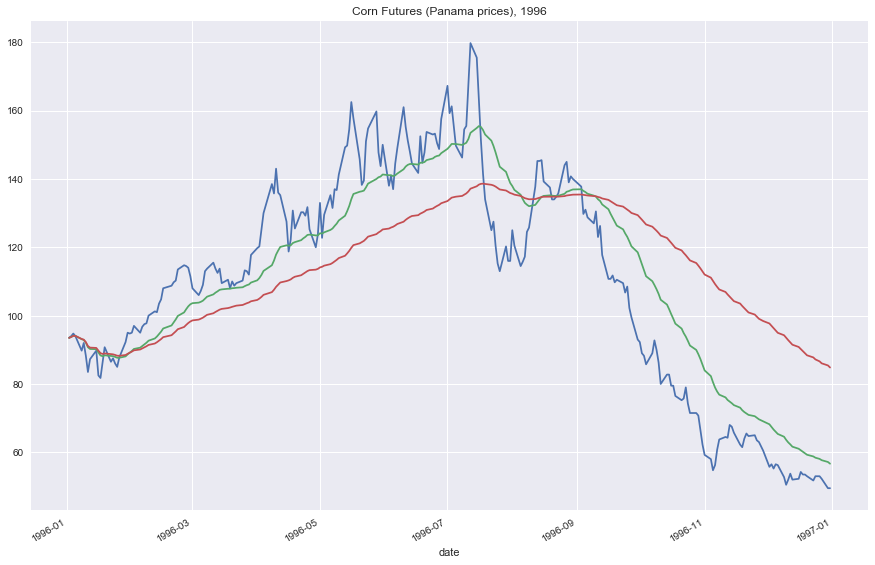

In [2]:
prices = i['corn'].panama_prices()['1996']
prices.plot(title="Corn Futures (Panama prices), 1996")
prices.ewm(span=30).mean().plot()
prices.ewm(span=120).mean().plot()

Here, we can see that when `EWMA(30) > EWMA(120)`, we are in an uptrend.
 
We prefer our forecasts to not be binary (all in or all out), but continuous. This means we can have small positions for weak trends, and larger positions for strong trends.
 
A better way to write this then would be:

    Forecast = EWMA(fast) - EWMA(slow)

This is good, but the result is in \$, which isn’t very useful. We can fix this by normalizing, as follows:
 
 $$\text{Forecast normalized} = 
     \frac{\text{Forecast} \times 10}
         {\text{Forecast.abs().mean()}}$$

This means that we get a forecast that has a `mean()` of 0, and an absolute mean (`.abs().mean()`) of 10 (i.e. the forecast usually hovers around -10 or 10). In our software, we would always clip something like this, so that extreme forecasts are not possible. The likelihood of forecasts would look like two Gaussians, centred on -10 and +10.

This forecast is called the **exponentially weighted moving average crossover** - or **EWMAC** for short.

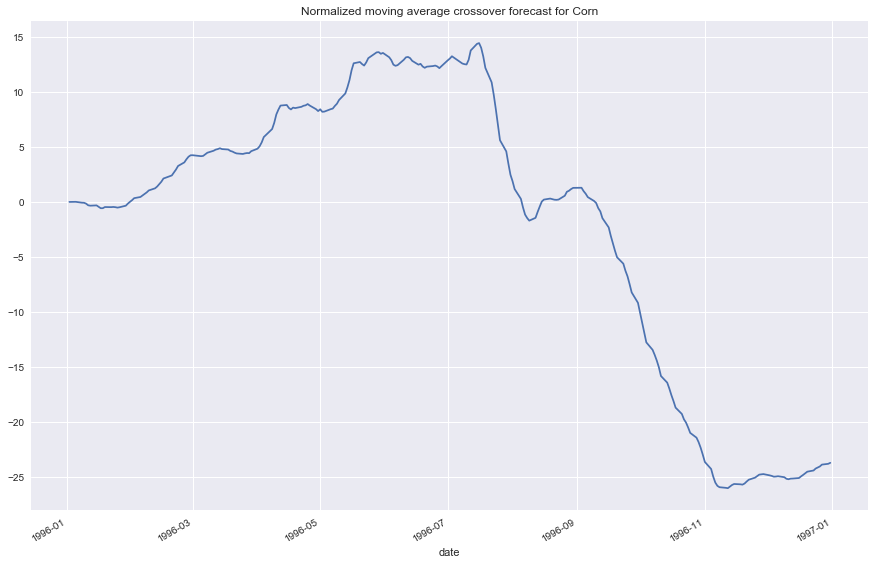

In [3]:
ewma_fast = prices.ewm(span=30).mean()
ewma_slow = prices.ewm(span=120).mean()
forecast = ewma_fast- ewma_slow
forecast_normalized = forecast * 10 / forecast.abs().mean()
forecast_normalized.plot(title = 'Normalized moving average crossover forecast for Corn')

## Putting it all together- getting the final position

So, to get our final position, we multiply our forecast/10 by our calculation earlier.            
               
$$\text{Position}=
    \frac{\text{Normalized forecast} \times \text{Daily volatility target} \times \text{Capital}}
        { 10 \times \text{Return Volatility of a single corn contract}}$$

Remember, when we think about setting up a position, we don't think about how much it will 'cost' (like we were buying stocks and shares). Because we're trading on margin, it costs nothing to buy, but we have to fit it into our volatility target. In this way, 'volatility' is the main thing we invest.

Below we calculate this for real.

Notes:
* The annual volatility target is 25% of 100000. We divide this by `sqrt(252)`, the number of trading days in a year, to get the **daily** volatility target.
* We divide by 10 because of the arbitrary centering on +10/-10 in our forecast above. **This is legacy code and we should probably take it out.**
* We divide by the recent volatility of a single contract. Doing this tells us how many contracts we need to own to make up our target volatility.

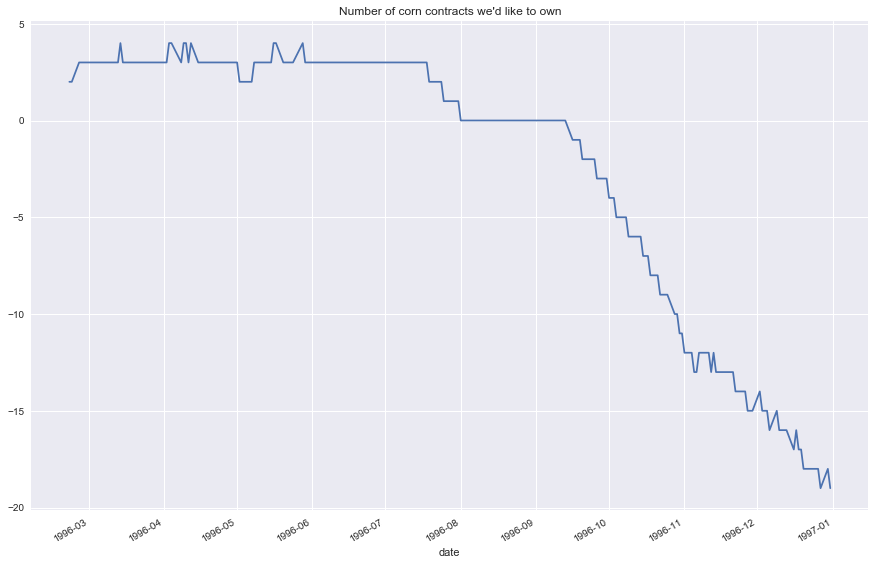

In [4]:
position = forecast_normalized * 0.25 * 1000/np.sqrt(252)\
            / (10* prices.diff().ewm(span=36, min_periods=36).std())
position.round().plot(title='Number of corn contracts we\'d like to own')